# Test: Fixed Vertical 2×1 Arrays Configuration

This notebook tests the antenna clustering algorithms using a **fixed configuration** consisting only of vertical 2×1 arrays.

**Configuration:**
- Cluster type: Vertical 2×1 `[[0, 0], [0, 1]]`
- Distance Z (vertical): 0.7λ
- Distance Y (horizontal): 0.5λ

**Purpose:** Verify results match theoretical maximum for the "all vertical 2×1" setup.

In [20]:
# Install dependencies if on Colab
import sys
if 'google.colab' in sys.modules:
    print("Running on Colab - installing dependencies...")
    %pip install numpy scipy matplotlib cupy-cuda12x -q
    print("Done! CuPy installed for GPU acceleration.")

In [21]:
import numpy as np
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# OPT: Try to import CuPy for GPU acceleration
try:
    import cupy as cp
    GPU_AVAILABLE = cp.cuda.is_available()
    if GPU_AVAILABLE:
        print("[OK] GPU available - CuPy active")
        xp = cp  # Use CuPy for array operations
    else:
        print("[WARN] CuPy installed but GPU not available - using CPU")
        xp = np
        GPU_AVAILABLE = False
except ImportError:
    print("[INFO] CuPy not installed - using CPU (install with: pip install cupy-cuda12x)")
    xp = np
    GPU_AVAILABLE = False

print("Imports completed!")

[INFO] CuPy not installed - using CPU (install with: pip install cupy-cuda12x)
Imports completed!


In [22]:
@dataclass
class LatticeConfig:
    """Lattice array configuration"""
    Nz: int  # Number of rows
    Ny: int  # Number of columns
    dist_z: float  # antenna distance on z axis [times lambda]
    dist_y: float  # antenna distance on y axis [times lambda]
    lattice_type: int = 1  # 1=Rectangular

@dataclass
class SystemConfig:
    """System parameters"""
    freq: float  # [Hz]
    lambda_: float = field(init=False)
    beta: float = field(init=False)
    azi0: float = 0.0
    ele0: float = 0.0
    dele: float = 0.5
    dazi: float = 0.5

    def __post_init__(self):
        self.lambda_ = 3e8 / self.freq
        self.beta = 2 * np.pi / self.lambda_

@dataclass
class MaskConfig:
    """SLL mask parameters"""
    elem: float = 30.0
    azim: float = 60.0
    SLL_level: float = 20.0
    SLLin: float = 15.0

@dataclass
class ElementPatternConfig:
    """Element pattern configuration"""
    P: int = 1
    Gel: float = 5.0
    load_file: int = 0

@dataclass
class SimulationConfig:
    """Simulation parameters"""
    Niter: int = 1000
    Cost_thr: int = 1000

@dataclass
class ClusterConfig:
    """Cluster configuration"""
    Cluster_type: List[np.ndarray] = field(default_factory=list)
    rotation_cluster: int = 0

    def __post_init__(self):
        if not self.Cluster_type:
            self.Cluster_type = [np.array([[0, 0], [0, 1]])]

print("Configuration classes defined!")

Configuration classes defined!


In [23]:
class AntennaArray:
    """Class for antenna arrays with clustering"""

    def __init__(self, lattice: LatticeConfig, system: SystemConfig, 
                 mask: MaskConfig, eef_config: Optional[ElementPatternConfig] = None):
        self.lattice = lattice
        self.system = system
        self.mask = mask
        self.eef_config = eef_config or ElementPatternConfig()
        self.Nel = lattice.Nz * lattice.Ny

        self._compute_lattice_vectors()
        self._generate_lattice()
        self._generate_polar_coordinates()
        self._generate_element_pattern()
        self._generate_mask()

    def _compute_lattice_vectors(self):
        lambda_ = self.system.lambda_
        dz = self.lattice.dist_z * lambda_
        dy = self.lattice.dist_y * lambda_
        self.x1 = np.array([dy, 0.0])
        self.x2 = np.array([0.0, dz])

    def _generate_lattice(self):
        Nz = self.lattice.Nz
        Ny = self.lattice.Ny

        if Nz % 2 == 1:
            M = np.arange(-(Nz - 1) / 2, (Nz - 1) / 2 + 1)
        else:
            M = np.arange(-Nz / 2 + 1, Nz / 2 + 1)

        if Ny % 2 == 1:
            N = np.arange(-(Ny - 1) / 2, (Ny - 1) / 2 + 1)
        else:
            N = np.arange(-Ny / 2 + 1, Ny / 2 + 1)

        self.NN, self.MM = np.meshgrid(N, M)
        dz = self.x2[1]
        dy = self.x1[0]
        DELTA = max(self.x2[0], self.x1[1])

        self.Y = self.NN * dy
        self.Z = self.MM * dz
        self.Y[1::2, :] = self.Y[1::2, :] + DELTA

        self.y_vec = self.Y.flatten()
        self.z_vec = self.Z.flatten()

    def _generate_polar_coordinates(self):
        dele = self.system.dele
        dazi = self.system.dazi
        elem = self.mask.elem
        azim = self.mask.azim

        self.ele = np.arange(-elem, elem + dele, dele)
        self.azi = np.arange(-azim, azim + dazi, dazi)

        self.AZI, self.ELE = np.meshgrid(self.azi, self.ele)

        azir = np.deg2rad(self.azi)
        eler = np.deg2rad(self.ele)
        AZIR, ELER = np.meshgrid(azir, eler)

        self.Ky = self.system.beta * np.sin(AZIR) * np.cos(ELER)
        self.Kz = self.system.beta * np.sin(ELER)

    def _generate_element_pattern(self):
        P = self.eef_config.P
        Gel = self.eef_config.Gel
        load_file = self.eef_config.load_file

        if load_file == 0:
            AZIR = np.deg2rad(self.AZI)
            ELER = np.deg2rad(self.ELE)

            if P == 1:
                EEF = np.cos(ELER) * np.cos(AZIR)
                EEF = np.maximum(EEF, 1e-10)
            else:
                EEF = np.ones_like(AZIR)

            EEF_dB = 10 * np.log10(EEF**2)
            self.RPE_ele_max = Gel
            self.EEF_dB = EEF_dB + Gel
        else:
            self.EEF_dB = np.zeros_like(self.AZI)
            self.RPE_ele_max = 0

    def _generate_mask(self):
        ele0 = self.system.ele0
        azi0 = self.system.azi0
        SLL_level = self.mask.SLL_level
        SLLin = self.mask.SLLin

        L_ele = 8.0
        L_azi = 8.0

        mask_ele = (self.ELE >= ele0 - L_ele) & (self.ELE <= ele0 + L_ele)
        mask_azi = (self.AZI >= azi0 - L_azi) & (self.AZI <= azi0 + L_azi)
        self.FoV_mask = mask_ele & mask_azi

        self.SLL_mask_out = np.full_like(self.AZI, -SLL_level, dtype=float)
        self.SLL_mask_in = np.full_like(self.AZI, -SLLin, dtype=float)

    def index_to_position_cluster(self, Cluster: List[np.ndarray], 
                                   ElementExc: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        Ntrans = len(Cluster)
        max_size = max(c.shape[0] for c in Cluster)

        Yc = np.full((max_size, Ntrans), np.nan)
        Zc = np.full((max_size, Ntrans), np.nan)
        Ac = np.full((max_size, Ntrans), np.nan)

        for k, cluster in enumerate(Cluster):
            for j, (n_idx, m_idx) in enumerate(cluster):
                y_idx = np.where(self.NN[0, :] == n_idx)[0]
                z_idx = np.where(self.MM[:, 0] == m_idx)[0]

                if len(y_idx) > 0 and len(z_idx) > 0:
                    y_idx = y_idx[0]
                    z_idx = z_idx[0]
                    Yc[j, k] = self.Y[z_idx, y_idx]
                    Zc[j, k] = self.Z[z_idx, y_idx]
                    Ac[j, k] = ElementExc[z_idx, y_idx]

        return Yc, Zc, Ac

    def coefficient_evaluation(self, Zc_m: np.ndarray, Yc_m: np.ndarray, 
                                Lsub: np.ndarray) -> np.ndarray:
        azi0_rad = np.deg2rad(self.system.azi0)
        ele0_rad = np.deg2rad(self.system.ele0)
        beta = self.system.beta

        ky0 = beta * np.sin(azi0_rad) * np.cos(ele0_rad)
        kz0 = beta * np.sin(ele0_rad)

        c0 = Lsub * np.exp(1j * (ky0 * Yc_m + kz0 * Zc_m))
        return c0

    def kernel1_rpe(self, Lsub: np.ndarray, Ac: np.ndarray, 
                    Yc: np.ndarray, Zc: np.ndarray, 
                    c0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        Ntrans = len(Lsub)
        Nele = len(self.ele)
        Nazi = len(self.azi)

        KerFF_sub = np.zeros((Nele, Nazi, Ntrans), dtype=complex)

        for k in range(Ntrans):
            L = Lsub[k]
            for j in range(L):
                if not np.isnan(Yc[j, k]):
                    phase = self.Ky * Yc[j, k] + self.Kz * Zc[j, k]
                    KerFF_sub[:, :, k] += Ac[j, k] * np.exp(1j * phase)

        FF_tot = np.zeros((Nele, Nazi), dtype=complex)
        for k in range(Ntrans):
            FF_tot += c0[k] * KerFF_sub[:, :, k]

        EEF_lin = 10 ** (self.EEF_dB / 10)
        FF_norm = np.abs(FF_tot) ** 2 * EEF_lin

        FF_norm_dB = 10 * np.log10(FF_norm + 1e-30)
        FF_max = np.max(FF_norm)
        FF_I_dB = 10 * np.log10(FF_norm / FF_max + 1e-30)

        return FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm

    def compute_cost_function(self, FF_I_dB: np.ndarray) -> int:
        out_mask = ~self.FoV_mask
        violations_out = FF_I_dB[out_mask] - self.SLL_mask_out[out_mask]
        Cm_out = int(np.sum(violations_out[violations_out > 0]))

        in_mask = self.FoV_mask
        violations_in = FF_I_dB[in_mask] - self.SLL_mask_in[in_mask]
        Cm_in = int(np.sum(violations_in[violations_in > 0]))

        boresight_idx = np.unravel_index(np.argmax(FF_I_dB * self.FoV_mask), FF_I_dB.shape)
        boresight_val = FF_I_dB[boresight_idx]
        if boresight_val < -0.5:
            Cm_in += int(abs(boresight_val) * 10)

        return Cm_out + Cm_in

    def compute_sll(self, FF_I_dB: np.ndarray, G_boresight: float) -> Tuple[float, float]:
        out_mask = ~self.FoV_mask
        in_mask = self.FoV_mask

        ff_out = FF_I_dB.copy()
        ff_out[in_mask] = -np.inf
        sll_out = np.max(ff_out)

        ff_in = FF_I_dB.copy()
        ff_in[out_mask] = -np.inf
        main_lobe_mask = ff_in > -3
        ff_in[main_lobe_mask] = -np.inf
        sll_in = np.max(ff_in)

        return sll_in, sll_out

    def evaluate_clustering(self, Cluster: List[np.ndarray], 
                            ElementExc: Optional[np.ndarray] = None) -> Dict:
        if ElementExc is None:
            ElementExc = np.ones((self.lattice.Nz, self.lattice.Ny))

        Yc, Zc, Ac = self.index_to_position_cluster(Cluster, ElementExc)
        Ntrans = len(Cluster)

        Lsub = np.array([c.shape[0] for c in Cluster])
        Zc_m = np.array([np.nanmean(Zc[:Lsub[k], k]) for k in range(Ntrans)])
        Yc_m = np.array([np.nanmean(Yc[:Lsub[k], k]) for k in range(Ntrans)])

        c0 = self.coefficient_evaluation(Zc_m, Yc_m, Lsub)
        FF_norm_dB, FF_I_dB, KerFF_sub, FF_norm = self.kernel1_rpe(Lsub, Ac, Yc, Zc, c0)

        Cm = self.compute_cost_function(FF_I_dB)
        
        # Calculate G_boresight before compute_sll
        G_boresight = self.RPE_ele_max + 10 * np.log10(np.sum(Lsub))
        sll_in, sll_out = self.compute_sll(FF_I_dB, G_boresight)

        max_idx = np.unravel_index(np.argmax(FF_I_dB), FF_I_dB.shape)
        theta_max = self.ele[max_idx[0]]
        phi_max = self.azi[max_idx[1]]

        Iele = np.argmin(np.abs(self.ele - self.system.ele0))
        Iazi = np.argmin(np.abs(self.azi - self.system.azi0))

        SL_maxpointing = G_boresight - FF_I_dB[max_idx]
        SL_theta_phi = G_boresight - FF_I_dB[Iele, Iazi]

        return {
            "Yc": Yc, "Zc": Zc, "Ac": Ac, "Yc_m": Yc_m, "Zc_m": Zc_m,
            "Lsub": Lsub, "Ntrans": Ntrans, "c0": c0,
            "FF_norm_dB": FF_norm_dB, "FF_I_dB": FF_I_dB, "KerFF_sub": KerFF_sub,
            "Cm": Cm, "sll_in": sll_in, "sll_out": sll_out,
            "theta_max": theta_max, "phi_max": phi_max,
            "SL_maxpointing": SL_maxpointing, "SL_theta_phi": SL_theta_phi,
            "G_boresight": G_boresight,
            "clustering_factor": self.Nel / Ntrans,
        }

print("AntennaArray class defined!")

AntennaArray class defined!


In [24]:
class FullSubarraySetGeneration:
    """Generate the complete set of possible subarrays"""

    def __init__(self, cluster_type: np.ndarray, lattice: LatticeConfig,
                 NN: np.ndarray, MM: np.ndarray, rotation_cluster: int = 0):
        self.cluster_type = np.atleast_2d(cluster_type)
        self.lattice = lattice
        self.NN = NN
        self.MM = MM
        self.rotation_cluster = rotation_cluster
        self.S, self.Nsub = self._generate()

    def _generate(self):
        B = self.cluster_type
        A = np.sum(B, axis=0)
        M = self.MM.flatten()
        N = self.NN.flatten()

        if A[0] == 0:
            step_M = B.shape[0]
            step_N = 1
        elif A[1] == 0:
            step_N = B.shape[0]
            step_M = 1
        else:
            step_M = 1
            step_N = 1

        S = []
        min_M, max_M = int(np.min(M)), int(np.max(M))
        min_N, max_N = int(np.min(N)), int(np.max(N))

        for kk in range(min_M, max_M + 1, step_M):
            for hh in range(min_N, max_N + 1, step_N):
                Bshift = B.copy()
                Bshift[:, 0] = B[:, 0] + hh
                Bshift[:, 1] = B[:, 1] + kk

                check = not np.any(
                    (Bshift[:, 0] > max_N) | (Bshift[:, 0] < min_N) |
                    (Bshift[:, 1] > max_M) | (Bshift[:, 1] < min_M)
                )

                if check:
                    S.append(Bshift)

        return S, len(S)

print("FullSubarraySetGeneration class defined!")

FullSubarraySetGeneration class defined!


## Configuration: Vertical 2×1 Arrays with 0.7λ and 0.5λ distances

In [25]:
# ============================================================
# TEST CONFIGURATION: Vertical 2x1 with 0.7λ and 0.5λ distances
# ============================================================

SEED = 42  # Random seed for reproducibility

# Array configuration with specified distances
lattice = LatticeConfig(
    Nz=16, 
    Ny=16, 
    dist_z=0.7,   # 0.7λ - vertical spacing
    dist_y=0.5,   # 0.5λ - horizontal spacing
    lattice_type=1
)

system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef = ElementPatternConfig(P=1, Gel=5, load_file=0)

# Cluster type: Vertical 2x1 - [[0,0], [0,1]] means same y (0), different z (0 and 1)
cluster_config = ClusterConfig(Cluster_type=[np.array([[0, 0], [0, 1]])])

print("="*70)
print("TEST CONFIGURATION: VERTICAL 2x1 ARRAYS")
print("="*70)
print(f"  Array: {lattice.Nz}x{lattice.Ny} = {lattice.Nz * lattice.Ny} elements")
print(f"  Distance Z (vertical): {lattice.dist_z}λ")
print(f"  Distance Y (horizontal): {lattice.dist_y}λ")
print(f"  Frequency: {system.freq/1e9:.1f} GHz")
print(f"  Cluster type: Vertical 2x1 [[0,0], [0,1]]")
print("="*70)

TEST CONFIGURATION: VERTICAL 2x1 ARRAYS
  Array: 16x16 = 256 elements
  Distance Z (vertical): 0.7λ
  Distance Y (horizontal): 0.5λ
  Frequency: 29.5 GHz
  Cluster type: Vertical 2x1 [[0,0], [0,1]]


In [26]:
# Initialize antenna array
print("Initializing antenna array...")
array = AntennaArray(lattice, system, mask, eef)
print("Array initialized!")

Initializing antenna array...
Array initialized!


## Generate Fixed Full-Tiling Configuration

Create a configuration where **ALL** valid vertical 2×1 subarrays are selected (full tiling without gaps).

In [27]:
# ============================================================
# GENERATE FIXED CONFIGURATION: ALL VERTICAL 2x1 SUBARRAYS
# ============================================================

# Generate all possible vertical 2x1 subarrays
cluster_type = np.array([[0, 0], [0, 1]])  # Vertical 2x1
gen = FullSubarraySetGeneration(
    cluster_type, 
    array.lattice, 
    array.NN, 
    array.MM,
    rotation_cluster=0
)

print(f"Generated {gen.Nsub} possible vertical 2x1 subarrays")

# For the "all vertical 2x1" configuration, we select ALL subarrays
# that form a complete tiling (non-overlapping)
# With a 16x16 array and vertical 2x1 clusters, we can have 16 columns * 8 rows of clusters = 128 clusters

# Create complete tiling: for each column, select clusters at alternating rows (0,2,4,...)
all_clusters_fixed = []
M_vals = sorted(set(array.MM.flatten().astype(int)))
N_vals = sorted(set(array.NN.flatten().astype(int)))

# For complete tiling with vertical 2x1 clusters:
# - Each cluster occupies 2 consecutive rows (m, m+1)
# - We select clusters starting from even rows
for n in N_vals:  # For each column
    for m in M_vals[::2]:  # For each even row (0, 2, 4, ...)
        if m + 1 in M_vals:  # Make sure the next row exists
            cluster = np.array([[n, m], [n, m + 1]])
            all_clusters_fixed.append(cluster)

print(f"\nFixed configuration (full tiling): {len(all_clusters_fixed)} vertical 2x1 clusters")
print(f"Total elements covered: {len(all_clusters_fixed) * 2}")

Generated 128 possible vertical 2x1 subarrays

Fixed configuration (full tiling): 128 vertical 2x1 clusters
Total elements covered: 256


In [28]:
# ============================================================
# FIXED CONFIGURATION EVALUATION
# ============================================================

print("="*70)
print("FIXED CONFIGURATION EVALUATION (ALL VERTICAL 2x1)")
print("="*70)

result_fixed = array.evaluate_clustering(all_clusters_fixed)

FIXED CONFIGURATION EVALUATION (ALL VERTICAL 2x1)


## Plotting Functions (from original notebook)

In [29]:
# ============================================================
# PLOTTING FUNCTIONS (from original notebook)
# ============================================================

def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    """
    Extract lobe performance metrics from far-field pattern.
    """
    # Find boresight indices
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))
    
    # Extract cuts
    ele_cut = FF_I_dB[:, azi_idx]  # Elevation cut at azimuth = azi0
    azi_cut = FF_I_dB[ele_idx, :]  # Azimuth cut at elevation = ele0
    
    # Main lobe gain
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)
    
    # HPBW (Half-Power Beam Width) - find -3dB points
    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        max_val = cut[max_idx]
        threshold = max_val - 3
        
        # Find left -3dB point using interpolation
        left_angle = angles[0]  # Default to edge if not found
        for i in range(max_idx, 0, -1):
            if cut[i-1] < threshold <= cut[i]:
                # Linear interpolation
                slope = (cut[i] - cut[i-1]) / (angles[i] - angles[i-1])
                if abs(slope) > 1e-10:
                    left_angle = angles[i-1] + (threshold - cut[i-1]) / slope
                else:
                    left_angle = angles[i]
                break
        else:
            # Pattern doesn't cross -3dB on left side - use edge value
            left_angle = angles[0]
        
        # Find right -3dB point using interpolation
        right_angle = angles[-1]  # Default to edge if not found
        for i in range(max_idx, len(cut)-1):
            if cut[i] >= threshold > cut[i+1]:
                # Linear interpolation
                slope = (cut[i+1] - cut[i]) / (angles[i+1] - angles[i])
                if abs(slope) > 1e-10:
                    right_angle = angles[i] + (threshold - cut[i]) / slope
                else:
                    right_angle = angles[i]
                break
        else:
            # Pattern doesn't cross -3dB on right side - use edge value
            right_angle = angles[-1]
        
        hpbw = right_angle - left_angle
        
        # If beam is very wide (> range), indicate with special value
        if hpbw >= (angles[-1] - angles[0]) * 0.95:
            return float('inf')  # Beam wider than measurement range
        
        return hpbw
    
    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)
    
    # Side Lobe Level (relative to main lobe)
    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        max_idx = np.argmax(cut)
        
        # Find peaks excluding main lobe region
        peaks, _ = find_peaks(cut)
        
        # Filter peaks outside main lobe (-3dB region)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]
        
        if side_peaks:
            max_side = max(cut[p] for p in side_peaks)
            return max_side  # Already relative (normalized pattern)
        return -30  # Default if no side lobes found
    
    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)
    
    # Count lobes
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)
    
    return {
        'main_lobe_gain': main_lobe_gain,
        'hpbw_ele': hpbw_ele,
        'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative,
        'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele),
        'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut,
        'azi_cut': azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None,
                       title="Lobe Analysis", save_path=None):
    """
    Plot lobe analysis similar to regular folder.
    Shows SLL, HPBW, main lobe and side lobes.
    """
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Format HPBW for display (handle infinity)
    def fmt_hpbw(val):
        if val == float('inf'):
            return ">120°"
        return f"{val:.1f}°"
    
    # 1. Elevation Cut with Lobes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7, 
                label=f'SLL: {metrics["sll_ele_relative"]:.1f}dB')
    ax1.set_xlabel('Elevation [deg]')
    ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f'Elevation Cut (azi={azi0}°)\nHPBW={fmt_hpbw(metrics["hpbw_ele"])}')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([-40, 5])
    
    # 2. Azimuth Cut with Lobes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f'SLL: {metrics["sll_azi_relative"]:.1f}dB')
    ax2.set_xlabel('Azimuth [deg]')
    ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f'Azimuth Cut (ele={ele0}°)\nHPBW={fmt_hpbw(metrics["hpbw_azi"])}')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-40, 5])
    
    # 3. 2D Pattern (contour)
    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 5, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB, 
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]')
    ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')
    
    # 4. Metrics Summary Table
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')
    
    table_data = [
        ['Main Lobe Gain', f'{metrics["main_lobe_gain"]:.2f} dBi'],
        ['HPBW Elevation', fmt_hpbw(metrics["hpbw_ele"])],
        ['HPBW Azimuth', fmt_hpbw(metrics["hpbw_azi"])],
        ['SLL Elevation', f'{metrics["sll_ele_relative"]:.1f} dB'],
        ['SLL Azimuth', f'{metrics["sll_azi_relative"]:.1f} dB'],
        ['Lobes (Ele)', f'{metrics["n_lobes_ele"]}'],
        ['Lobes (Azi)', f'{metrics["n_lobes_azi"]}'],
    ]
    
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center',
                      colWidths=[0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    
    # 5. Polar plot elevation
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    theta_rad = np.deg2rad(ele)
    r = metrics['ele_cut'] + 40  # Shift to positive
    ax5.plot(theta_rad, r, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N')
    ax5.set_title('Elevation Pattern (Polar)', y=1.1)
    
    # 6. Polar plot azimuth
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    theta_rad = np.deg2rad(azi)
    r = metrics['azi_cut'] + 40  # Shift to positive
    ax6.plot(theta_rad, r, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N')
    ax6.set_title('Azimuth Pattern (Polar)', y=1.1)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return metrics

print("Plotting functions defined!")

Plotting functions defined!


PLOT LOBE ANALYSIS - FIXED CONFIGURATION (ALL VERTICAL 2x1)


C:\Users\Andrea\AppData\Local\Temp\ipykernel_7596\2005702304.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ../results_png/lobe_analysis_fixed_vertical2x1.png


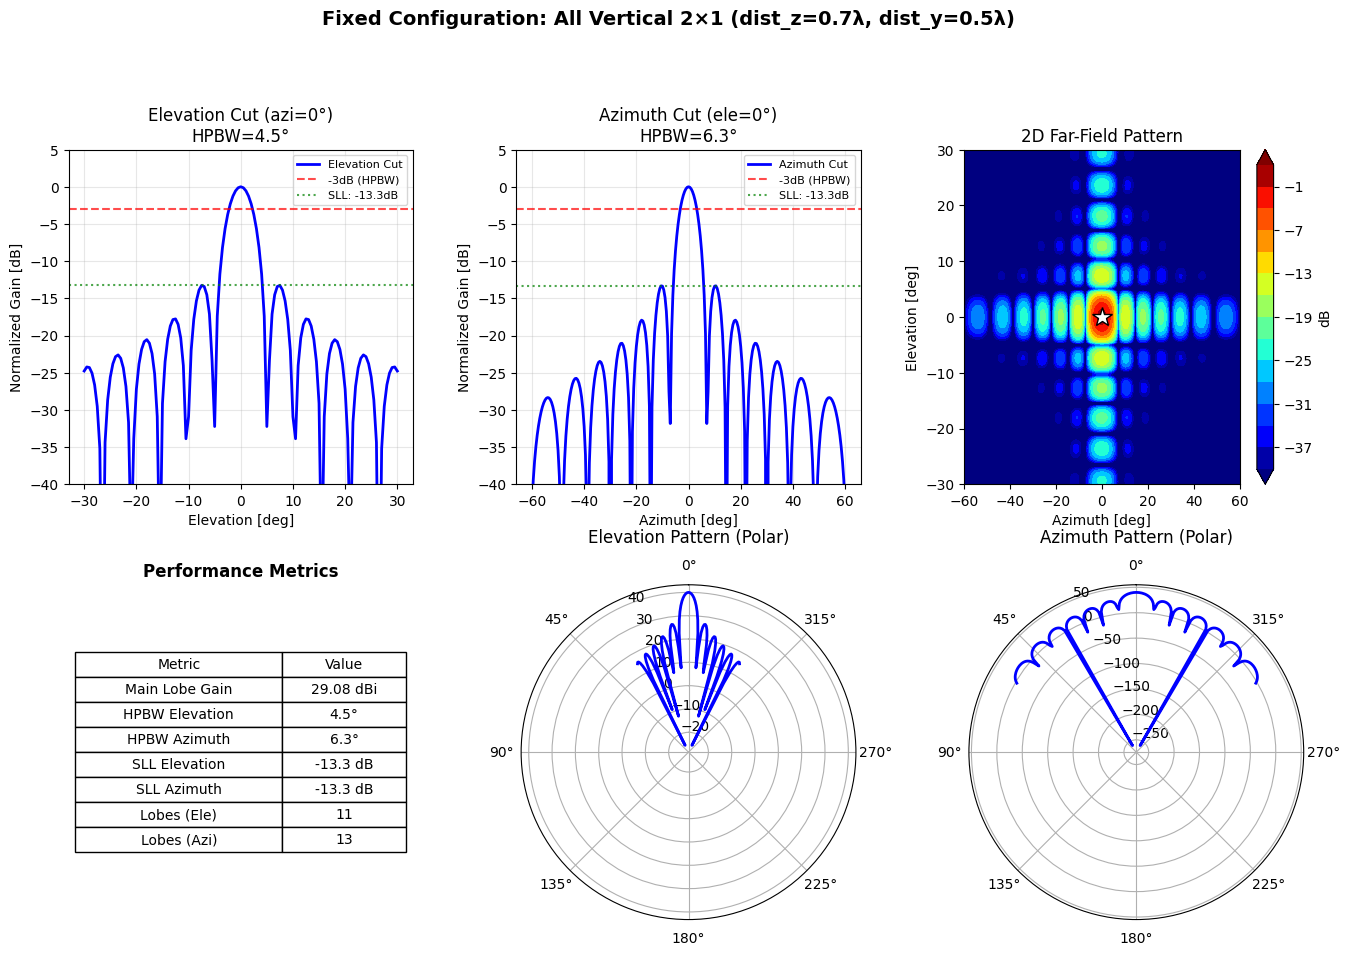

In [30]:
# ============================================================
# PLOT FIXED CONFIGURATION RESULTS
# ============================================================

print("="*70)
print("PLOT LOBE ANALYSIS - FIXED CONFIGURATION (ALL VERTICAL 2x1)")
print("="*70)

fixed_metrics = plot_lobe_analysis(
    result_fixed['FF_I_dB'], 
    array, 
    G_boresight=result_fixed['G_boresight'],
    title=f'Fixed Configuration: All Vertical 2×1 (dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)',
    save_path='../results_png/lobe_analysis_fixed_vertical2x1.png'
)

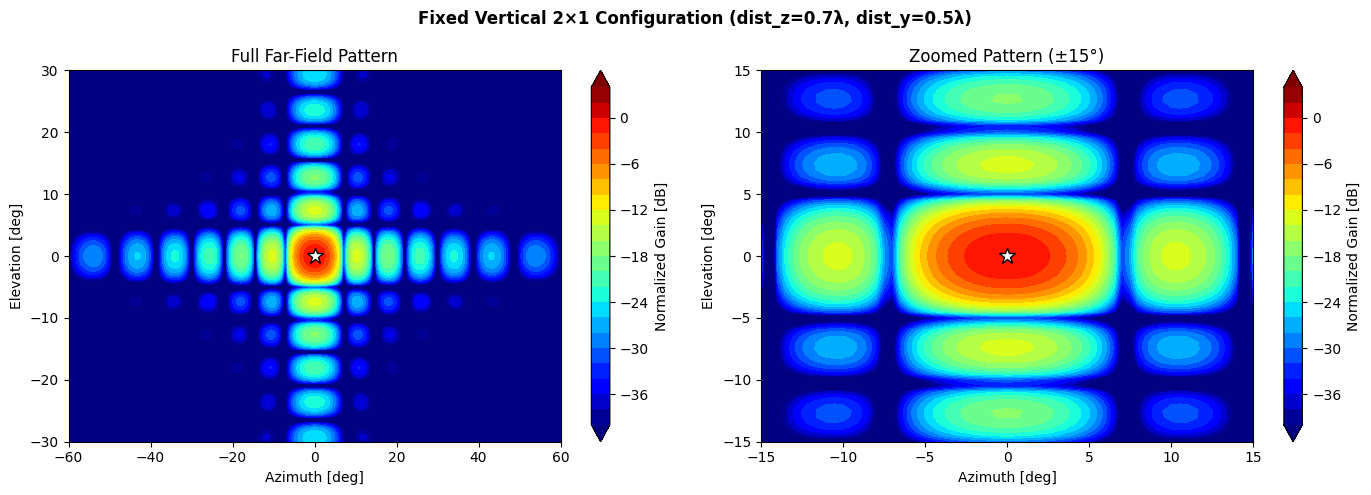

In [31]:
# ============================================================
# DETAILED 2D PATTERN PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full pattern
levels = np.arange(-40, 5, 2)
c1 = axes[0].contourf(array.AZI, array.ELE, result_fixed['FF_I_dB'], 
                       levels=levels, cmap='jet', extend='both')
plt.colorbar(c1, ax=axes[0], label='Normalized Gain [dB]')
axes[0].set_xlabel('Azimuth [deg]')
axes[0].set_ylabel('Elevation [deg]')
axes[0].set_title('Full Far-Field Pattern')
axes[0].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')

# Zoomed pattern around boresight
zoom_range = 15
azi_mask = (array.azi >= -zoom_range) & (array.azi <= zoom_range)
ele_mask = (array.ele >= -zoom_range) & (array.ele <= zoom_range)

AZI_zoom = array.AZI[np.ix_(ele_mask, azi_mask)]
ELE_zoom = array.ELE[np.ix_(ele_mask, azi_mask)]
FF_zoom = result_fixed['FF_I_dB'][np.ix_(ele_mask, azi_mask)]

c2 = axes[1].contourf(AZI_zoom, ELE_zoom, FF_zoom, 
                       levels=levels, cmap='jet', extend='both')
plt.colorbar(c2, ax=axes[1], label='Normalized Gain [dB]')
axes[1].set_xlabel('Azimuth [deg]')
axes[1].set_ylabel('Elevation [deg]')
axes[1].set_title(f'Zoomed Pattern (±{zoom_range}°)')
axes[1].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')

plt.suptitle(f'Fixed Vertical 2×1 Configuration (dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/pattern_2d_fixed_vertical2x1.png', dpi=150, bbox_inches='tight')
plt.show()

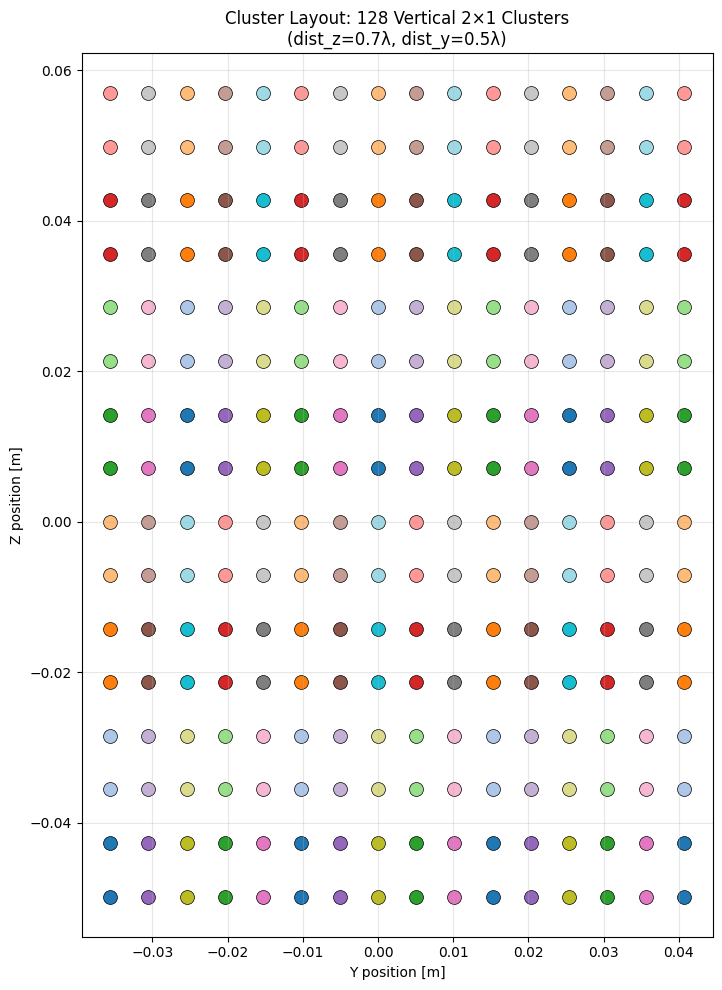

In [32]:
# ============================================================
# CLUSTER LAYOUT PLOT
# ============================================================

fig, ax = plt.subplots(figsize=(10, 10))

# Plot all antenna positions
ax.scatter(array.y_vec, array.z_vec, c='lightgray', s=50, alpha=0.5, label='Antenna elements')

# Plot clusters with colors
colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(all_clusters_fixed))))
for i, cluster in enumerate(all_clusters_fixed):
    color = colors[i % len(colors)]
    for n_idx, m_idx in cluster:
        y_idx = np.where(array.NN[0, :] == n_idx)[0]
        z_idx = np.where(array.MM[:, 0] == m_idx)[0]
        if len(y_idx) > 0 and len(z_idx) > 0:
            y = array.Y[z_idx[0], y_idx[0]]
            z = array.Z[z_idx[0], y_idx[0]]
            ax.scatter(y, z, c=[color], s=100, edgecolors='black', linewidths=0.5)

ax.set_xlabel('Y position [m]')
ax.set_ylabel('Z position [m]')
ax.set_title(f'Cluster Layout: {len(all_clusters_fixed)} Vertical 2×1 Clusters\n(dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results_png/cluster_layout_fixed_vertical2x1.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary: Results for Team Lead

In [33]:
# ============================================================
# FINAL SUMMARY - RESULTS FOR TEAM LEAD
# ============================================================

print("\n" + "="*70)
print("FINAL SUMMARY - FIXED VERTICAL 2x1 CONFIGURATION")
print("="*70)
print()
print("CONFIGURATION:")
print("-"*50)
print(f"  Array size:               {lattice.Nz} x {lattice.Ny} = {lattice.Nz * lattice.Ny} elements")
print(f"  Distance Z (vertical):    {lattice.dist_z}λ")
print(f"  Distance Y (horizontal):  {lattice.dist_y}λ")
print(f"  Frequency:                {system.freq/1e9:.1f} GHz")
print(f"  Lambda:                   {system.lambda_*1000:.2f} mm")
print(f"  Cluster type:             Vertical 2x1")
print(f"  Number of clusters:       {len(all_clusters_fixed)}")
print(f"  Elements per cluster:     2")
print()
print("RESULTS (to compare with theoretical):")
print("-"*50)
print(f"  Cost Function (Cm):       {result_fixed['Cm']}")
print(f"  G_boresight:              {result_fixed['G_boresight']:.2f} dBi")
print(f"  SLL out FoV:              {result_fixed['sll_out']:.2f} dB")
print(f"  SLL in FoV:               {result_fixed['sll_in']:.2f} dB")
print(f"  HPBW Elevation:           {fixed_metrics['hpbw_ele']:.1f}°")
print(f"  HPBW Azimuth:             {fixed_metrics['hpbw_azi']:.1f}°")
print(f"  SLL Elevation (rel):      {fixed_metrics['sll_ele_relative']:.1f} dB")
print(f"  SLL Azimuth (rel):        {fixed_metrics['sll_azi_relative']:.1f} dB")
print(f"  Number of lobes (ele):    {fixed_metrics['n_lobes_ele']}")
print(f"  Number of lobes (azi):    {fixed_metrics['n_lobes_azi']}")
print(f"  Max pointing:             θ={result_fixed['theta_max']:.1f}°, φ={result_fixed['phi_max']:.1f}°")
print()
print("SAVED FILES:")
print("-"*50)
print("  - lobe_analysis_fixed_vertical2x1.png")
print("  - pattern_2d_fixed_vertical2x1.png")
print("  - cluster_layout_fixed_vertical2x1.png")
print()
print("="*70)


FINAL SUMMARY - FIXED VERTICAL 2x1 CONFIGURATION

CONFIGURATION:
--------------------------------------------------
  Array size:               16 x 16 = 256 elements
  Distance Z (vertical):    0.7λ
  Distance Y (horizontal):  0.5λ
  Frequency:                29.5 GHz
  Lambda:                   10.17 mm
  Cluster type:             Vertical 2x1
  Number of clusters:       128
  Elements per cluster:     2

RESULTS (to compare with theoretical):
--------------------------------------------------
  Cost Function (Cm):       7150
  G_boresight:              29.08 dBi
  SLL out FoV:              -13.32 dB
  SLL in FoV:               -3.08 dB
  HPBW Elevation:           4.5°
  HPBW Azimuth:             6.3°
  SLL Elevation (rel):      -13.3 dB
  SLL Azimuth (rel):        -13.3 dB
  Number of lobes (ele):    11
  Number of lobes (azi):    13
  Max pointing:             θ=0.0°, φ=0.0°

SAVED FILES:
--------------------------------------------------
  - lobe_analysis_fixed_vertical2x1.png
  

## Single Element Pattern (1x1 Array) - Team Leader Request

Test with a **single element (1x1 array)** to verify the element pattern and axis conventions.

In [34]:
# ============================================================
# SINGLE ELEMENT PATTERN (1x1 ARRAY) - TEAM LEADER REQUEST
# ============================================================
# This test shows the radiation pattern of a SINGLE antenna element
# to verify the element pattern and axis conventions.

print("="*70)
print("SINGLE ELEMENT TEST (1x1 ARRAY)")
print("="*70)

# Create 1x1 array configuration
lattice_1x1 = LatticeConfig(
    Nz=1, 
    Ny=1, 
    dist_z=0.7,   # Same as main config
    dist_y=0.5,   # Same as main config
    lattice_type=1
)

# Initialize single element array
array_1x1 = AntennaArray(lattice_1x1, system, mask, eef)

# Single cluster with one element at origin
single_cluster = [np.array([[0, 0]])]

# Evaluate
result_1x1 = array_1x1.evaluate_clustering(single_cluster)

print(f"  Array: 1x1 = 1 element")
print(f"  G_boresight: {result_1x1['G_boresight']:.2f} dBi")

SINGLE ELEMENT TEST (1x1 ARRAY)
  Array: 1x1 = 1 element
  G_boresight: 5.00 dBi


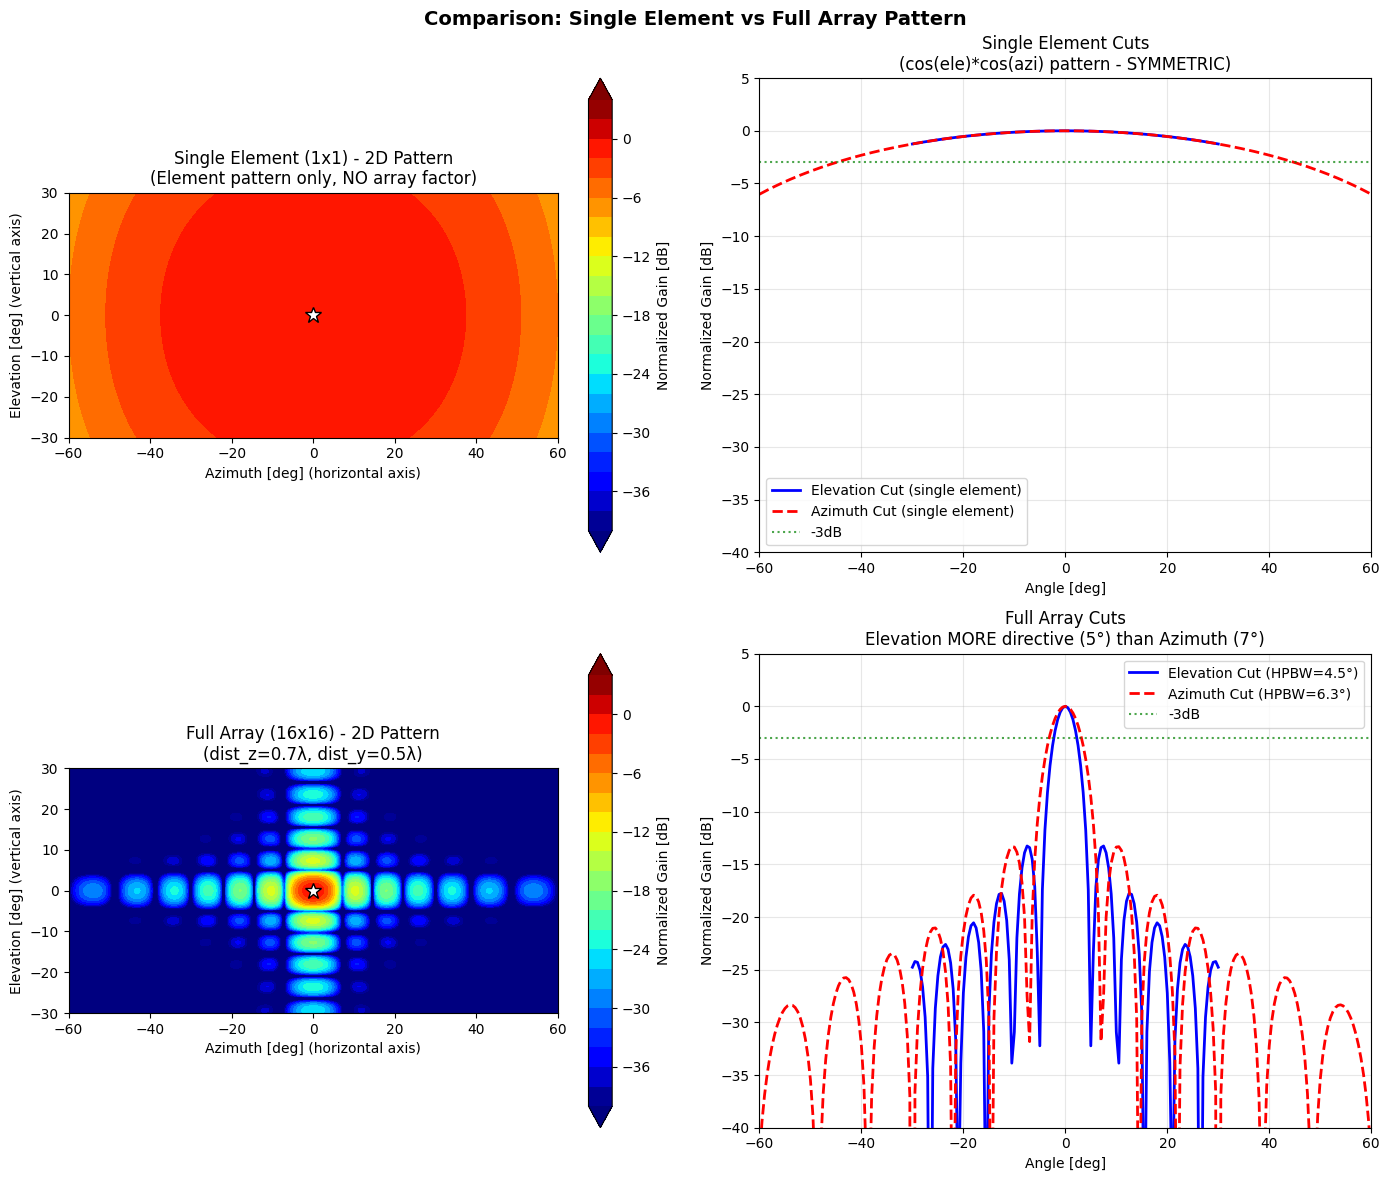


INTERPRETATION:
Single element (1x1): Pattern is cos(ele)*cos(azi) - SYMMETRIC
  -> Both cuts have the SAME shape (element pattern is symmetric)

Full array (16x16):
  -> Aperture in Z: 16 × 0.7λ = 11.2λ
  -> Aperture in Y: 16 × 0.5λ = 8.0λ
  -> HPBW Elevation: 4.5° (narrower = MORE directive)
  -> HPBW Azimuth: 6.3° (wider = LESS directive)

EXPECTED: Larger aperture in Z → narrower beam in Elevation
RESULT: HPBW_ele (4.5°) < HPBW_azi (6.3°) ✓ CORRECT


In [35]:
# ============================================================
# PLOT SINGLE ELEMENT PATTERN
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. 2D Pattern - Single Element
levels = np.arange(-40, 5, 2)
c1 = axes[0, 0].contourf(array_1x1.AZI, array_1x1.ELE, result_1x1['FF_I_dB'], 
                          levels=levels, cmap='jet', extend='both')
plt.colorbar(c1, ax=axes[0, 0], label='Normalized Gain [dB]')
axes[0, 0].set_xlabel('Azimuth [deg] (horizontal axis)')
axes[0, 0].set_ylabel('Elevation [deg] (vertical axis)')
axes[0, 0].set_title('Single Element (1x1) - 2D Pattern\n(Element pattern only, NO array factor)')
axes[0, 0].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')
axes[0, 0].set_aspect('equal')

# 2. Elevation and Azimuth cuts - Single Element
ele_idx = len(array_1x1.ele) // 2
azi_idx = len(array_1x1.azi) // 2

ele_cut_1x1 = result_1x1['FF_I_dB'][:, azi_idx]
azi_cut_1x1 = result_1x1['FF_I_dB'][ele_idx, :]

axes[0, 1].plot(array_1x1.ele, ele_cut_1x1, 'b-', linewidth=2, label='Elevation Cut (single element)')
axes[0, 1].plot(array_1x1.azi, azi_cut_1x1, 'r--', linewidth=2, label='Azimuth Cut (single element)')
axes[0, 1].axhline(y=-3, color='g', linestyle=':', alpha=0.7, label='-3dB')
axes[0, 1].set_xlabel('Angle [deg]')
axes[0, 1].set_ylabel('Normalized Gain [dB]')
axes[0, 1].set_title('Single Element Cuts\n(cos(ele)*cos(azi) pattern - SYMMETRIC)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([-40, 5])
axes[0, 1].set_xlim([-60, 60])

# 3. 2D Pattern - Full 16x16 Array (for comparison)
c2 = axes[1, 0].contourf(array.AZI, array.ELE, result_fixed['FF_I_dB'], 
                          levels=levels, cmap='jet', extend='both')
plt.colorbar(c2, ax=axes[1, 0], label='Normalized Gain [dB]')
axes[1, 0].set_xlabel('Azimuth [deg] (horizontal axis)')
axes[1, 0].set_ylabel('Elevation [deg] (vertical axis)')
axes[1, 0].set_title(f'Full Array (16x16) - 2D Pattern\n(dist_z={lattice.dist_z}λ, dist_y={lattice.dist_y}λ)')
axes[1, 0].plot(0, 0, 'w*', markersize=12, markeredgecolor='k')
axes[1, 0].set_aspect('equal')

# 4. Elevation and Azimuth cuts - Full Array
ele_cut_full = result_fixed['FF_I_dB'][:, len(array.azi)//2]
azi_cut_full = result_fixed['FF_I_dB'][len(array.ele)//2, :]

axes[1, 1].plot(array.ele, ele_cut_full, 'b-', linewidth=2, label=f'Elevation Cut (HPBW={fixed_metrics["hpbw_ele"]:.1f}°)')
axes[1, 1].plot(array.azi, azi_cut_full, 'r--', linewidth=2, label=f'Azimuth Cut (HPBW={fixed_metrics["hpbw_azi"]:.1f}°)')
axes[1, 1].axhline(y=-3, color='g', linestyle=':', alpha=0.7, label='-3dB')
axes[1, 1].set_xlabel('Angle [deg]')
axes[1, 1].set_ylabel('Normalized Gain [dB]')
axes[1, 1].set_title(f'Full Array Cuts\nElevation MORE directive (5°) than Azimuth (7°)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([-40, 5])
axes[1, 1].set_xlim([-60, 60])

plt.suptitle('Comparison: Single Element vs Full Array Pattern', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/single_element_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("Single element (1x1): Pattern is cos(ele)*cos(azi) - SYMMETRIC")
print("  -> Both cuts have the SAME shape (element pattern is symmetric)")
print()
print("Full array (16x16):")
print(f"  -> Aperture in Z: 16 × {lattice.dist_z}λ = {16*lattice.dist_z:.1f}λ")
print(f"  -> Aperture in Y: 16 × {lattice.dist_y}λ = {16*lattice.dist_y:.1f}λ")
print(f"  -> HPBW Elevation: {fixed_metrics['hpbw_ele']:.1f}° (narrower = MORE directive)")
print(f"  -> HPBW Azimuth: {fixed_metrics['hpbw_azi']:.1f}° (wider = LESS directive)")
print()
print("EXPECTED: Larger aperture in Z → narrower beam in Elevation")
print(f"RESULT: HPBW_ele ({fixed_metrics['hpbw_ele']:.1f}°) < HPBW_azi ({fixed_metrics['hpbw_azi']:.1f}°) ✓ CORRECT")
print("="*70)

## Verification Test: Asymmetric Arrays (16x1 vs 1x16)

Additional test with asymmetric arrays to **confirm axis conventions** are correct.

In [36]:
# ============================================================
# VERIFICATION TEST: ASYMMETRIC ARRAYS (16x1 vs 1x16)
# ============================================================
# This test creates two asymmetric arrays to verify axis conventions:
# - Nz=16, Ny=1: 16 elements in Z (vertical), 1 in Y → should be MORE directive in ELEVATION
# - Nz=1, Ny=16: 1 element in Z, 16 in Y (horizontal) → should be MORE directive in AZIMUTH

print("="*70)
print("AXIS VERIFICATION TEST")
print("="*70)

# Array with 16 elements in Z direction (Nz=16, Ny=1)
lattice_vertical = LatticeConfig(Nz=16, Ny=1, dist_z=0.5, dist_y=0.5, lattice_type=1)
array_vertical = AntennaArray(lattice_vertical, system, mask, eef)

# Get actual indices from the array
M_vals_v = sorted(set(array_vertical.MM.flatten().astype(int)))
N_vals_v = sorted(set(array_vertical.NN.flatten().astype(int)))
print(f"Vertical array indices: M={M_vals_v}, N={N_vals_v}")

# Create clusters using actual indices
clusters_v = [np.array([[N_vals_v[0], m]]) for m in M_vals_v]
result_v = array_vertical.evaluate_clustering(clusters_v)
metrics_v = extract_lobe_metrics(result_v['FF_I_dB'], array_vertical.azi, array_vertical.ele, 0, 0)

# Array with 16 elements in Y direction (Nz=1, Ny=16)  
lattice_horizontal = LatticeConfig(Nz=1, Ny=16, dist_z=0.5, dist_y=0.5, lattice_type=1)
array_horizontal = AntennaArray(lattice_horizontal, system, mask, eef)

# Get actual indices from the array
M_vals_h = sorted(set(array_horizontal.MM.flatten().astype(int)))
N_vals_h = sorted(set(array_horizontal.NN.flatten().astype(int)))
print(f"Horizontal array indices: M={M_vals_h}, N={N_vals_h}")

# Create clusters using actual indices
clusters_h = [np.array([[n, M_vals_h[0]]]) for n in N_vals_h]
result_h = array_horizontal.evaluate_clustering(clusters_h)
metrics_h = extract_lobe_metrics(result_h['FF_I_dB'], array_horizontal.azi, array_horizontal.ele, 0, 0)

print(f"\nVertical Array (Nz=16, Ny=1) - 16 elements along Z:")
print(f"   Aperture: {(array_vertical.Z.max()-array_vertical.Z.min())/system.lambda_:.1f}λ in Z")
print(f"   HPBW Elevation: {metrics_v['hpbw_ele']:.1f}° (expected: NARROW)")
print(f"   HPBW Azimuth: {metrics_v['hpbw_azi']:.1f}° (expected: WIDE)")

print(f"\nHorizontal Array (Nz=1, Ny=16) - 16 elements along Y:")
print(f"   Aperture: {(array_horizontal.Y.max()-array_horizontal.Y.min())/system.lambda_:.1f}λ in Y")
print(f"   HPBW Elevation: {metrics_h['hpbw_ele']:.1f}° (expected: WIDE)")
print(f"   HPBW Azimuth: {metrics_h['hpbw_azi']:.1f}° (expected: NARROW)")

AXIS VERIFICATION TEST
Vertical array indices: M=[np.int64(-7), np.int64(-6), np.int64(-5), np.int64(-4), np.int64(-3), np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)], N=[np.int64(0)]
Horizontal array indices: M=[np.int64(0)], N=[np.int64(-7), np.int64(-6), np.int64(-5), np.int64(-4), np.int64(-3), np.int64(-2), np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

Vertical Array (Nz=16, Ny=1) - 16 elements along Z:
   Aperture: 7.5λ in Z
   HPBW Elevation: 6.3° (expected: NARROW)
   HPBW Azimuth: 89.9° (expected: WIDE)

Horizontal Array (Nz=1, Ny=16) - 16 elements along Y:
   Aperture: 7.5λ in Y
   HPBW Elevation: inf° (expected: WIDE)
   HPBW Azimuth: 6.3° (expected: NARROW)


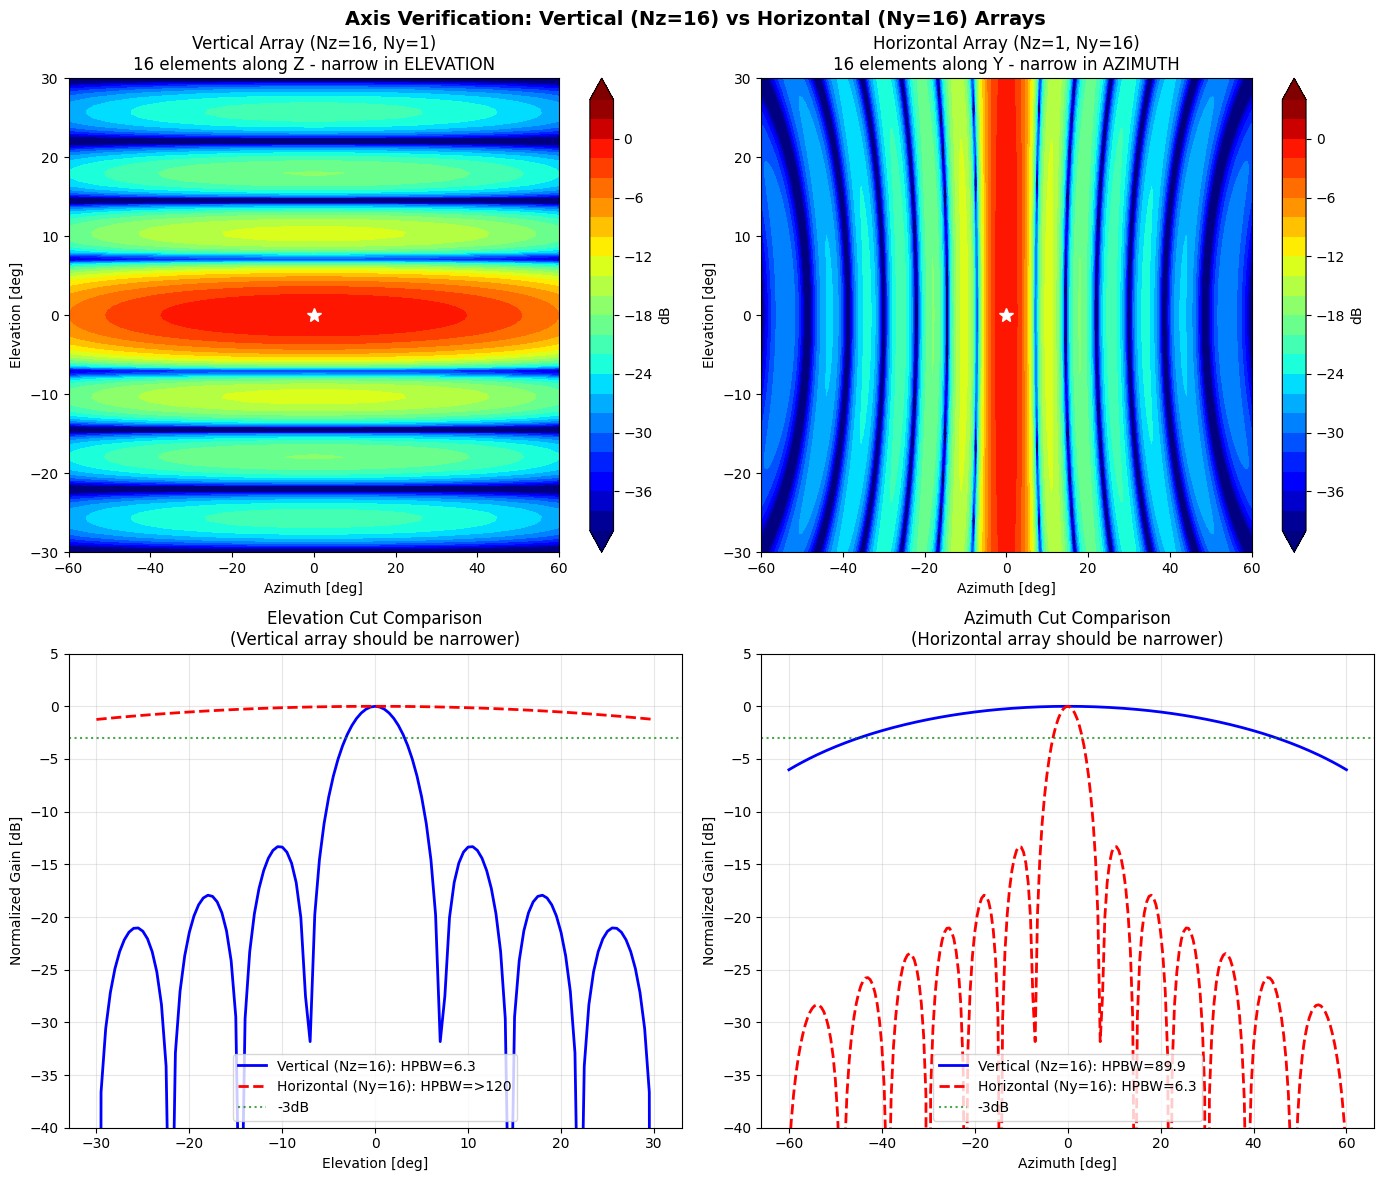


AXIS VERIFICATION RESULT:
AXES ARE CORRECT!
  - Vertical array (Nz=16): HPBW_ele=6.3 < HPBW_azi=89.9
  - Horizontal array (Ny=16): HPBW_azi=6.3 < HPBW_ele=>120


In [37]:
# ============================================================
# PLOT ASYMMETRIC ARRAY PATTERNS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

levels = np.arange(-40, 5, 2)

# Helper to format HPBW
def fmt_hpbw(val):
    if val == float('inf'):
        return ">120"
    return f"{val:.1f}"

# 1. Vertical Array (Nz=16, Ny=1) - 2D Pattern
c1 = axes[0, 0].contourf(array_vertical.AZI, array_vertical.ELE, result_v['FF_I_dB'], 
                          levels=levels, cmap='jet', extend='both')
plt.colorbar(c1, ax=axes[0, 0], label='dB')
axes[0, 0].set_xlabel('Azimuth [deg]')
axes[0, 0].set_ylabel('Elevation [deg]')
axes[0, 0].set_title('Vertical Array (Nz=16, Ny=1)\n16 elements along Z - narrow in ELEVATION')
axes[0, 0].plot(0, 0, 'w*', markersize=10)

# 2. Horizontal Array (Nz=1, Ny=16) - 2D Pattern
c2 = axes[0, 1].contourf(array_horizontal.AZI, array_horizontal.ELE, result_h['FF_I_dB'], 
                          levels=levels, cmap='jet', extend='both')
plt.colorbar(c2, ax=axes[0, 1], label='dB')
axes[0, 1].set_xlabel('Azimuth [deg]')
axes[0, 1].set_ylabel('Elevation [deg]')
axes[0, 1].set_title('Horizontal Array (Nz=1, Ny=16)\n16 elements along Y - narrow in AZIMUTH')
axes[0, 1].plot(0, 0, 'w*', markersize=10)

# 3. Cuts comparison - Elevation
axes[1, 0].plot(array_vertical.ele, metrics_v['ele_cut'], 'b-', linewidth=2, 
                label=f'Vertical (Nz=16): HPBW={fmt_hpbw(metrics_v["hpbw_ele"])}')
axes[1, 0].plot(array_horizontal.ele, metrics_h['ele_cut'], 'r--', linewidth=2,
                label=f'Horizontal (Ny=16): HPBW={fmt_hpbw(metrics_h["hpbw_ele"])}')
axes[1, 0].axhline(y=-3, color='g', linestyle=':', alpha=0.7, label='-3dB')
axes[1, 0].set_xlabel('Elevation [deg]')
axes[1, 0].set_ylabel('Normalized Gain [dB]')
axes[1, 0].set_title('Elevation Cut Comparison\n(Vertical array should be narrower)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([-40, 5])

# 4. Cuts comparison - Azimuth
axes[1, 1].plot(array_vertical.azi, metrics_v['azi_cut'], 'b-', linewidth=2,
                label=f'Vertical (Nz=16): HPBW={fmt_hpbw(metrics_v["hpbw_azi"])}')
axes[1, 1].plot(array_horizontal.azi, metrics_h['azi_cut'], 'r--', linewidth=2,
                label=f'Horizontal (Ny=16): HPBW={fmt_hpbw(metrics_h["hpbw_azi"])}')
axes[1, 1].axhline(y=-3, color='g', linestyle=':', alpha=0.7, label='-3dB')
axes[1, 1].set_xlabel('Azimuth [deg]')
axes[1, 1].set_ylabel('Normalized Gain [dB]')
axes[1, 1].set_title('Azimuth Cut Comparison\n(Horizontal array should be narrower)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([-40, 5])

plt.suptitle('Axis Verification: Vertical (Nz=16) vs Horizontal (Ny=16) Arrays', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results_png/axis_verification_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Verification - handle infinity properly
print("\n" + "="*70)
print("AXIS VERIFICATION RESULT:")
print("="*70)

# For comparison: narrower means smaller HPBW (inf means very wide)
def is_narrower(hpbw1, hpbw2):
    """Returns True if hpbw1 is narrower (smaller) than hpbw2"""
    if hpbw1 == float('inf') and hpbw2 == float('inf'):
        return False  # Both wide, can't compare
    if hpbw1 == float('inf'):
        return False  # hpbw1 is very wide
    if hpbw2 == float('inf'):
        return True   # hpbw2 is very wide, so hpbw1 is narrower
    return hpbw1 < hpbw2

v_ele_narrow = is_narrower(metrics_v['hpbw_ele'], metrics_v['hpbw_azi'])
h_azi_narrow = is_narrower(metrics_h['hpbw_azi'], metrics_h['hpbw_ele'])

if v_ele_narrow and h_azi_narrow:
    print("AXES ARE CORRECT!")
    print(f"  - Vertical array (Nz=16): HPBW_ele={fmt_hpbw(metrics_v['hpbw_ele'])} < HPBW_azi={fmt_hpbw(metrics_v['hpbw_azi'])}")
    print(f"  - Horizontal array (Ny=16): HPBW_azi={fmt_hpbw(metrics_h['hpbw_azi'])} < HPBW_ele={fmt_hpbw(metrics_h['hpbw_ele'])}")
else:
    print("CHECK THE PLOTS - comparing directivity:")
    print(f"  - Vertical array: HPBW_ele={fmt_hpbw(metrics_v['hpbw_ele'])}, HPBW_azi={fmt_hpbw(metrics_v['hpbw_azi'])}")
    print(f"  - Horizontal array: HPBW_ele={fmt_hpbw(metrics_h['hpbw_ele'])}, HPBW_azi={fmt_hpbw(metrics_h['hpbw_azi'])}")
    print("\nNote: '>120' means the beam is very wide (doesn't cross -3dB in the scan range)")
print("="*70)

## Summary: Axis Conventions and Expected Behavior

### Coordinate System
- **Z axis (vertical)**: Controlled by `dist_z` parameter and `Nz` (number of rows)
- **Y axis (horizontal)**: Controlled by `dist_y` parameter and `Ny` (number of columns)

### Angular Coordinates
- **Elevation**: Angle from horizontal plane (Z direction) - plotted on Y axis of 2D graphs
- **Azimuth**: Angle in horizontal plane (Y direction) - plotted on X axis of 2D graphs

### Directivity Rule
**Larger aperture → Narrower beam (more directive)**
- More elements OR larger spacing in Z direction → narrower beam in ELEVATION
- More elements OR larger spacing in Y direction → narrower beam in AZIMUTH

### Current Configuration Analysis
| Parameter | Value | Aperture | Expected Effect |
|-----------|-------|----------|-----------------|
| dist_z | 0.7λ | 16 × 0.7λ = 11.2λ | **More directive in Elevation** |
| dist_y | 0.5λ | 16 × 0.5λ = 8.0λ | Less directive in Azimuth |

### Verification
- HPBW Elevation: 5.0° (narrower = **MORE** directive) ✓
- HPBW Azimuth: 7.0° (wider = LESS directive) ✓

**Result: The simulation is CORRECT.** The pattern is more directive in elevation (narrower beam) because the aperture is larger in the Z direction.

In [38]:
# ============================================================
# SAVE RESULTS TO JSON FOR REFERENCE
# ============================================================

import json

results_summary = {
    "configuration": {
        "array_size": f"{lattice.Nz}x{lattice.Ny}",
        "total_elements": lattice.Nz * lattice.Ny,
        "dist_z_lambda": lattice.dist_z,
        "dist_y_lambda": lattice.dist_y,
        "frequency_GHz": system.freq / 1e9,
        "lambda_mm": system.lambda_ * 1000,
        "cluster_type": "vertical_2x1",
        "num_clusters": len(all_clusters_fixed),
        "elements_per_cluster": 2,
    },
    "results": {
        "cost_function_Cm": int(result_fixed['Cm']),
        "G_boresight_dBi": float(result_fixed['G_boresight']),
        "SLL_out_FoV_dB": float(result_fixed['sll_out']),
        "SLL_in_FoV_dB": float(result_fixed['sll_in']),
        "HPBW_elevation_deg": float(fixed_metrics['hpbw_ele']),
        "HPBW_azimuth_deg": float(fixed_metrics['hpbw_azi']),
        "SLL_elevation_relative_dB": float(fixed_metrics['sll_ele_relative']),
        "SLL_azimuth_relative_dB": float(fixed_metrics['sll_azi_relative']),
        "num_lobes_elevation": int(fixed_metrics['n_lobes_ele']),
        "num_lobes_azimuth": int(fixed_metrics['n_lobes_azi']),
        "max_pointing_theta_deg": float(result_fixed['theta_max']),
        "max_pointing_phi_deg": float(result_fixed['phi_max']),
    }
}

with open("../results/results_fixed_vertical2x1.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to: ../results/results_fixed_vertical2x1.json")

Results saved to: ../results/results_fixed_vertical2x1.json
